In [3]:
# Importing Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np



In [4]:
#LEt us see how we can implement a quantum walk on a 4-dimensional hypercube. 
#The circuit will have 6 qubits, 4 to represent the posn and 2 to represent the coin (Grover's coin)
one_step_circuit = QuantumCircuit(6, name=' ONE STEP') 
# Coin operator
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])
one_step_circuit.draw() 

q_0: ──────────────────
                       
q_1: ──────────────────
                       
q_2: ──────────────────
                       
q_3: ──────────────────
     ┌───┐┌───┐   ┌───┐
q_4: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_5: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

In [5]:
#This is how we shift the coin, as we know, the coin can move only one space, so keeping that in mind, we write this: 
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,4):
        circuit.x(4)
        if i%2==0:
            circuit.x(5)
        circuit.ccx(4,5,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw() 

┌───┐                              
q_0: ───────────────────────┤ X ├──────────────────────────────
                            └─┬─┘     ┌───┐                    
q_1: ─────────────────────────┼───────┤ X ├────────────────────
                              │       └─┬─┘     ┌───┐          
q_2: ─────────────────────────┼─────────┼───────┤ X ├──────────
                              │         │       └─┬─┘     ┌───┐
q_3: ─────────────────────────┼─────────┼─────────┼───────┤ X ├
     ┌───┐┌───┐   ┌───┐┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐└─┬─┘
q_4: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
     ├───┤├───┤ │ ├───┤├───┤  │  └───┘  │  ├───┤  │  └───┘  │  
q_5: ┤ H ├┤ Z ├─■─┤ H ├┤ X ├──■─────────■──┤ X ├──■─────────■──
     └───┘└───┘   └───┘└───┘               └───┘

In [6]:
#Now we will inverse the gate that we have created, because we need to reverse the phase estimation at later stages
one_step_circuit.inverse().draw() 

┌───┐                       
q_0: ──────────────────────────────┤ X ├───────────────────────
                         ┌───┐     └─┬─┘                       
q_1: ────────────────────┤ X ├───────┼─────────────────────────
               ┌───┐     └─┬─┘       │                         
q_2: ──────────┤ X ├───────┼─────────┼─────────────────────────
     ┌───┐     └─┬─┘       │         │                         
q_3: ┤ X ├───────┼─────────┼─────────┼─────────────────────────
     └─┬─┘┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐┌───┐   ┌───┐┌───┐
q_4: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
       │  └───┘  │  ├───┤  │  └───┘  │  ├───┤├───┤ │ ├───┤├───┤
q_5: ──■─────────■──┤ X ├──■─────────■──┤ X ├┤ H ├─■─┤ Z ├┤ H ├
                    └───┘               └───┘└───┘   └───┘└───┘

In [7]:
# Making controlled gates from the gate and the inverse gate 
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

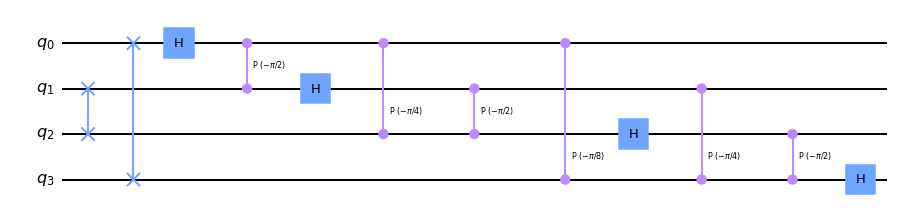

In [8]:
#Using QFT function from Qiskit to implement the Quantum Fourier Transform. Since phase estimation uses reverse QFT, we have
#reversed the circuit, to make the use easier. 
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

In [9]:
#the second phase of the algorithm is all about making an oracle that marks two states, the 1011 and 1111 state. 
#This step can be explained from the coin quantum walks, where both the coin state and the position state 
#are represented by vectors in Hilbert space
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Marking state 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mct([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)
# Marking state 1111
phase_circuit.h(3)
phase_circuit.mct([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()
# Creating the phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw() 

q_0: ───────■──────────────■───────
            │              │       
q_1: ───────■──────────────■───────
     ┌───┐  │  ┌───┐       │       
q_2: ┤ X ├──■──┤ X ├───────■───────
     ├───┤┌─┴─┐├───┤┌───┐┌─┴─┐┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘
q_4: ──────────────────────────────
                                   
q_5: ──────────────────────────────

In [10]:
# So, what this code does is that a gate is implemented that rotates the state of the qubit present, if the other qubits
#are not zero, and then the qubit will be used in the phase estimation
#Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

┌───┐               ┌───┐
q_0: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_1: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_2: ┤ X ├──■─────────■──┤ X ├
     ├───┤  │         │  ├───┤
q_3: ┤ X ├──■─────────■──┤ X ├
     ├───┤┌─┴─┐┌───┐┌─┴─┐├───┤
q_4: ┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

In [12]:
#doing the phase estimation, (some parts of this have been copied as I didn't fully understand them)

phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Applying the IFT
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Here we are defining all the angles that are not zero with the auxiliary qubit, but have some definite angle. 
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reversing the phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw() 

┌───┐┌──────────────┐                                                »
 q_0: ┤ H ├┤0             ├────────────────────────────────────────────────»
      ├───┤│              │┌──────────────┐┌──────────────┐                »
 q_1: ┤ H ├┤              ├┤0             ├┤0             ├────────────────»
      ├───┤│              ││              ││              │┌──────────────┐»
 q_2: ┤ H ├┤              ├┤              ├┤              ├┤0             ├»
      ├───┤│              ││              ││              ││              │»
 q_3: ┤ H ├┤              ├┤              ├┤              ├┤              ├»
      └───┘│              ││              ││              ││              │»
 q_4: ─────┤1             ├┤1             ├┤1             ├┤1             ├»
           │  c_ ONE STEP ││              ││              ││              │»
 q_5: ─────┤2             ├┤2 c_ ONE STEP ├┤2 c_ ONE STEP ├┤2             ├»
           │              ││              ││              ││  c_ ONE STEP │»
 q_6: ─────┤3             ├┤3             ├┤3             ├┤3             ├»
           │              ││              ││              ││              │»
 q_7: ─────┤4             ├┤4             ├┤4             ├┤4             ├»
           │              ││              ││              ││              │»
 q_8: ─────┤5             ├┤5             ├┤5             ├┤5             ├»
           │              ││              ││              ││              │»
 q_9: ─────┤6             ├┤6             ├┤6             ├┤6             ├»
           └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
q_10: ─────────────────────────────────────────────────────────────────────»
                                                                           »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐                »
« q_2: ┤0             ├┤0             ├┤0             ├────────────────»
«      │              ││              ││              │┌──────────────┐»
« q_3: ┤              ├┤              ├┤              ├┤0             ├»
«      │              ││              ││              ││              │»
« q_4: ┤1             ├┤1             ├┤1             ├┤1             ├»
«      │              ││              ││              ││              │»
« q_5: ┤2             ├┤2             ├┤2             ├┤2             ├»
«      │  c_ ONE STEP ││  c_ ONE STEP ││  c_ ONE STEP ││              │»
« q_6: ┤3             ├┤3             ├┤3             ├┤3 c_ ONE STEP ├»
«      │              ││              ││              ││              │»
« q_7: ┤4             ├┤4             ├┤4             ├┤4             ├»
«      │              ││              ││              ││              │»
« q_8: ┤5             ├┤5             ├┤5             ├┤5             ├»
«      │              ││              ││              ││              │»
« q_9: ┤6             ├┤6             ├┤6             ├┤6             ├»
«      └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«q_10: ────────────────────────────────────────────────────────────────»
«                                                                      »
«                                                                      »
« q_0: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_1: ────────────────────────────────────────────────────────────────»
«                                                                      »
« q_2: ────────────────────────────────────────────────────────────────»
«      ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
« q_3: ┤0             ├┤0             ├┤0    

In [13]:
# All the gates have been made and now it is time to implement the Quantum walk algorithm
# First up, a Hadamard gate will be applied to the 6 qubits, which ave the node and coin values.  
# And then we apply our custom created gates, the phase oracle gate and the phase estimation gate. 


theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)

# Applying Hadamard gates. 
circuit.h([4,5,6,7,8,9])
iterations = 2

#iteratively applhying the two gates. 
for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

#lastly, measuring the node qubits
circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw()

┌──────────────────────┐»
    theta_0: ────────────────────────┤0                     ├»
                                     │                      │»
    theta_1: ────────────────────────┤1                     ├»
                                     │                      │»
    theta_2: ────────────────────────┤2                     ├»
                                     │                      │»
    theta_3: ────────────────────────┤3                     ├»
             ┌───┐┌─────────────────┐│                      │»
     node_0: ┤ H ├┤0                ├┤4                     ├»
             ├───┤│                 ││                      │»
     node_1: ┤ H ├┤1                ├┤5   phase estimation  ├»
             ├───┤│                 ││                      │»
     node_2: ┤ H ├┤2                ├┤6                     ├»
             ├───┤│   phase oracle  ││                      │»
     node_3: ┤ H ├┤3                ├┤7                     ├»
             ├───┤│                 ││                      │»
     coin_0: ┤ H ├┤4                ├┤8                     ├»
             ├───┤│                 ││                      │»
     coin_1: ┤ H ├┤5                ├┤9                     ├»
             └───┘└─────────────────┘│                      │»
auxiliary_0: ────────────────────────┤10                    ├»
                                     └──────────────────────┘»
        c: 4/════════════════════════════════════════════════»
                                                             »
«                                ┌──────────────────────┐            
«    theta_0: ───────────────────┤0                     ├────────────
«                                │                      │            
«    theta_1: ───────────────────┤1                     ├────────────
«                                │                      │            
«    theta_2: ───────────────────┤2                     ├────────────
«                                │                      │            
«    theta_3: ───────────────────┤3                     ├────────────
«             ┌─────────────────┐│                      │┌─┐         
«     node_0: ┤0                ├┤4                     ├┤M├─────────
«             │                 ││                      │└╥┘┌─┐      
«     node_1: ┤1                ├┤5   phase estimation  ├─╫─┤M├──────
«             │                 ││                      │ ║ └╥┘┌─┐   
«     node_2: ┤2                ├┤6                     ├─╫──╫─┤M├───
«             │   phase oracle  ││                      │ ║  ║ └╥┘┌─┐
«     node_3: ┤3                ├┤7                     ├─╫──╫──╫─┤M├
«             │                 ││                      │ ║  ║  ║ └╥┘
«     coin_0: ┤4                ├┤8                     ├─╫──╫──╫──╫─
«             │                 ││                      │ ║  ║  ║  ║ 
«     coin_1: ┤5                ├┤9                     ├─╫──╫──╫──╫─
«             └─────────────────┘│                      │ ║  ║  ║  ║ 
«auxiliary_0: ───────────────────┤10                    ├─╫──╫──╫──╫─
«                                └──────────────────────┘ ║  ║  ║  ║ 
«        c: 4/════════════════════════════════════════════╩══╩══╩══╩═
«                                                         0  1  2  3

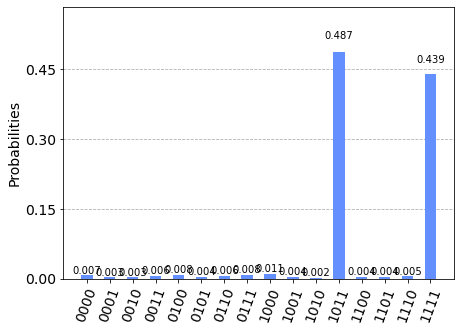

In [14]:
backend = Aer.get_backend('qasm_simulator') 
job = execute( circuit, backend, shots=1024 ) 
hist = job.result().get_counts() 
plot_histogram( hist )


In [ ]:
# Here, we can see that the circuit has collapsed on these states the highest number of times, making these the clear choices.
# Due to the superposition quality of qubits, a quantum walk will take all possible paths simultaneously
# until we measure the circuit. Now, due to the property of quantum Interference, some states will cancel out.
# This is exacly how we get the speedup from the classical algos, as we can design them in such a way 
#that wrong answers quickly cancels out.